<a href="https://colab.research.google.com/github/sadrireza/Neural-Networks/blob/main/Sat_Seg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Satellite Image Segmentation Project

# Step 1: Download the dataset if it doesn't exist locally

In [20]:
import os
import zipfile
import gdown

# Define paths
local_path = '/content/ign'  # Adjust this path if you're running locally
online_link = 'https://drive.google.com/uc?id=1y73mUPzS5Hhq1RjPXc9bxch-Nv6HlJem'  # Update to direct download link
annotations_path = '/content/ign/ign/annotations'
images_path = '/content/ign/ign/images'

# Download and extract dataset if not found locally
if not os.path.exists(local_path):
    print(f"Dataset not found at {local_path}. Downloading from {online_link}...")
    gdown.download(online_link, '/content/dataset.zip', quiet=False)
    with zipfile.ZipFile('/content/dataset.zip', 'r') as zip_ref:
        zip_ref.extractall(local_path)
    print("Download and extraction complete.")

In [14]:
# Function to list contents of a directory
def list_dir_contents(path):
    for root, dirs, files in os.walk(path):
        level = root.replace(path, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print('{}{}'.format(subindent, f))

# List the contents of the extracted dataset to verify structure
list_dir_contents(local_path)

ign/
    ign/
        annotations/
            training/
                c61_0960_6390.png
                c12_0920_6390.png
                c20_0935_6400.png
                c34_0935_6390.png
                c10_0920_6390.png
                c24_0935_6390.png
                c9_0975_6425.png
                c58_0920_6390.png
                c8_0915_6395.png
                c21_0975_6425.png
                c14_0955_6380.png
                c61_0935_6400.png
                c24_0935_6400.png
                c10_0935_6400.png
                c65_0935_6400.png
                c50_0955_6380.png
                c56_0975_6425.png
                c82_0920_6390.png
                c61_0990_6405.png
                c25_0960_6390.png
                c94_0915_6395.png
                c81_0935_6390.png
                c37_0955_6380.png
                c98_0955_6380.png
                c34_0955_6380.png
                c74_0935_6400.png
                c26_0990_6405.png
                c52_0935_63

# Step 2: Load and preprocess the dataset

In [24]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_images_from_folder(folder, color_mode='rgb'):
    images = []
    for filename in os.listdir(folder):
        img = load_img(os.path.join(folder, filename), target_size=(256, 256), color_mode=color_mode)
        img_array = img_to_array(img)
        images.append(img_array)
    return np.array(images)

# Load training and validation datasets
train_images = load_images_from_folder(os.path.join(images_path, 'training'), color_mode='rgb')
train_annotations = load_images_from_folder(os.path.join(annotations_path, 'training'), color_mode='grayscale')
val_images = load_images_from_folder(os.path.join(images_path, 'validation'), color_mode='rgb')
val_annotations = load_images_from_folder(os.path.join(annotations_path, 'validation'), color_mode='grayscale')

# Normalize images and annotations
train_images = train_images / 255.0
val_images = val_images / 255.0
train_annotations = train_annotations / 255.0
val_annotations = val_annotations / 255.0

# Expand dimensions of annotations to match model output
train_annotations = np.expand_dims(train_annotations, axis=-1)
val_annotations = np.expand_dims(val_annotations, axis=-1)

# Step 3: Build the segmentation model

In [25]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model

def build_model(input_shape):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(p2)

    # Decoder
    u4 = UpSampling2D((2, 2))(c3)
    c4 = Conv2D(32, (3, 3), activation='relu', padding='same')(u4)
    u5 = UpSampling2D((2, 2))(c4)
    c5 = Conv2D(16, (3, 3), activation='relu', padding='same')(u5)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)

    model = Model(inputs, outputs)
    return model

# Initialize and compile the model
model = build_model((256, 256, 3))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model to ensure it has less than 10 million parameters
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_12 (Conv2D)          (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 128, 128, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 64, 64, 64)        1849


# Step 4: Train the model

In [26]:
history = model.fit(train_images, train_annotations, validation_data=(val_images, val_annotations), epochs=10, batch_size=16)

Epoch 1/10
38/38 [==============================] - 156s 4s/step - loss: 0.1375 - accuracy: 0.1126 - val_loss: 0.0442 - val_accuracy: 0.1217
Epoch 2/10
38/38 [==============================] - 151s 4s/step - loss: 0.0423 - accuracy: 0.1143 - val_loss: 0.0384 - val_accuracy: 0.1217
Epoch 3/10
38/38 [==============================] - 151s 4s/step - loss: 0.0364 - accuracy: 0.1143 - val_loss: 0.0344 - val_accuracy: 0.1217
Epoch 4/10
38/38 [==============================] - 141s 4s/step - loss: 0.0349 - accuracy: 0.1143 - val_loss: 0.0339 - val_accuracy: 0.1217
Epoch 5/10
38/38 [==============================] - 152s 4s/step - loss: 0.0349 - accuracy: 0.1143 - val_loss: 0.0339 - val_accuracy: 0.1217
Epoch 6/10
38/38 [==============================] - 152s 4s/step - loss: 0.0346 - accuracy: 0.1143 - val_loss: 0.0337 - val_accuracy: 0.1217
Epoch 7/10
38/38 [==============================] - 151s 4s/step - loss: 0.0346 - accuracy: 0.1143 - val_loss: 0.0336 - val_accuracy: 0.1217
Epoch 8/10
38

# Step 5: Evaluate the model

7/7 [==============================] - 14s 2s/step
Average Dice Coefficient: 0.006286169821823814


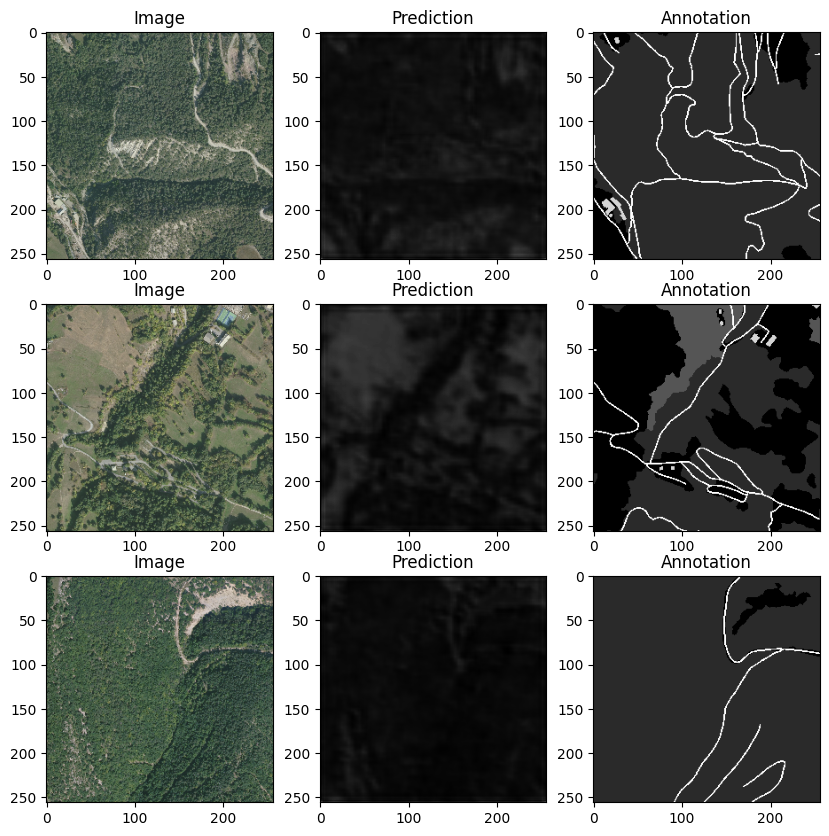

In [27]:
def dice_coef(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    smooth = 0.0001
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def dice_coef_multilabel(y_true, y_pred, numLabels):
    dice = 0
    for index in range(numLabels):
        dice += dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index])
    return dice / numLabels

# Make predictions on the validation set
val_predictions = model.predict(val_images)

# Calculate average Dice coefficient
average_dice = dice_coef_multilabel(val_annotations, val_predictions, numLabels=1)
print(f"Average Dice Coefficient: {average_dice}")

# Visualize a few predictions
import matplotlib.pyplot as plt

def plot_sample_images(images, predictions, annotations):
    plt.figure(figsize=(10, 10))
    for i in range(3):
        plt.subplot(3, 3, i*3+1)
        plt.imshow(images[i])
        plt.title('Image')
        plt.subplot(3, 3, i*3+2)
        plt.imshow(predictions[i].squeeze(), cmap='gray')
        plt.title('Prediction')
        plt.subplot(3, 3, i*3+3)
        plt.imshow(annotations[i].squeeze(), cmap='gray')
        plt.title('Annotation')
    plt.show()

plot_sample_images(val_images, val_predictions, val_annotations)